# Introduction

Short description of data

### Data import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import interpolate

from sklearn.utils import shuffle

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectKBest, f_classif,mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
import time


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

import seaborn as sns

# Creating final dataset
df = []

# Read class data
data = pd.read_csv('../data/files.csv')

#tsfeat=tsfeat.dropna(axis=1) # delete NaN columns
#tsfeat = tsfeat.drop('Unnamed: 0', axis=1)
#tsfeat = tsfeat.loc[:,~tsfeat.columns.str.startswith('3_')]

i = 0
for filename in os.listdir('../data/Train2'):
    df.append(pd.read_csv(os.path.join('../data/Train2',filename),header = None, names = ['x','y','z','time']))
    i = i + 1    

labels = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,2,2,2,3,3]) # Classificazione richiesta con 3 classi (moving,falling,other)
#data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8]) # Classificazione con 8 classi

In [2]:
def pre_process_data(data_acc, fs):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    data_act_acc = np.array(data_act_acc)
    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # concatenate interpolated data
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

In [3]:
df_resampled = df.copy()
for i in range(len(df)):
    df_resampled[i] = pre_process_data(df[i], 200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


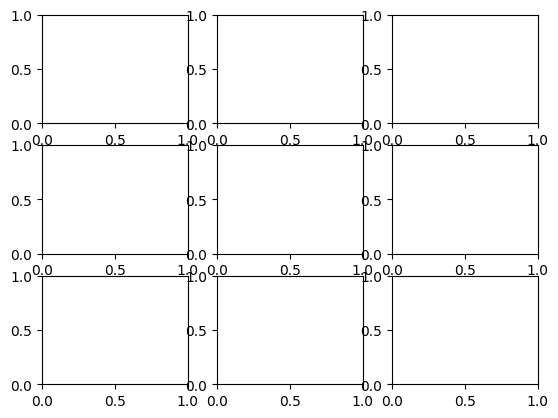

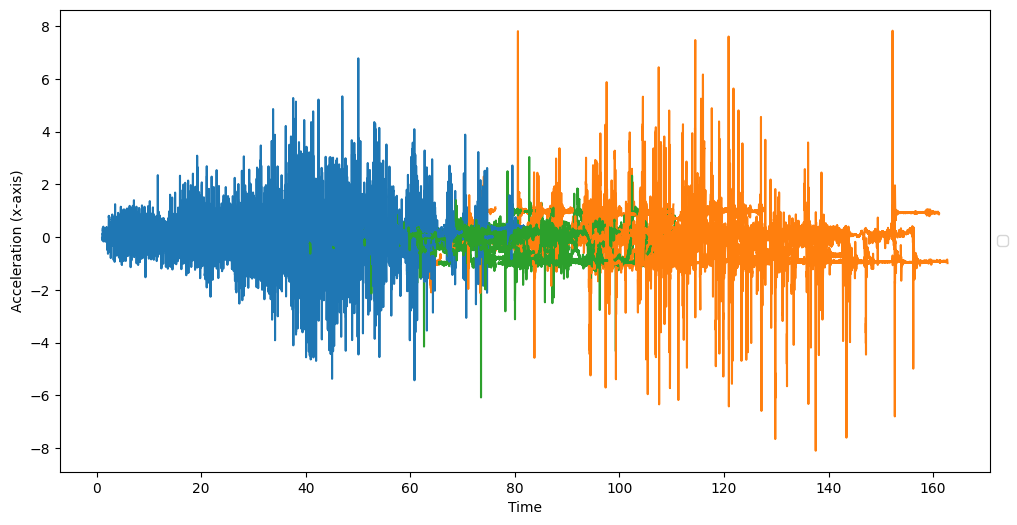

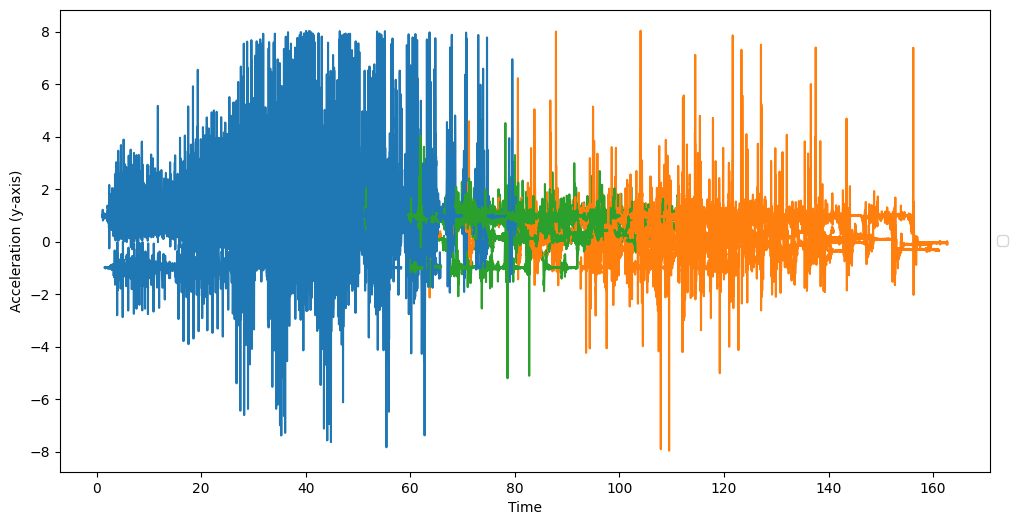

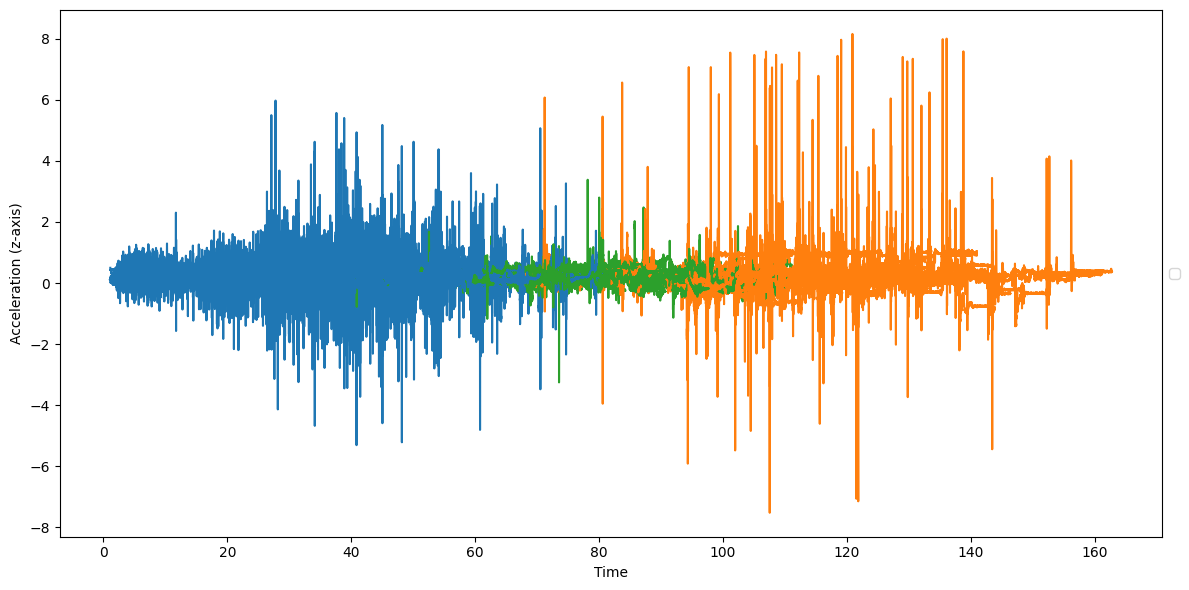

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


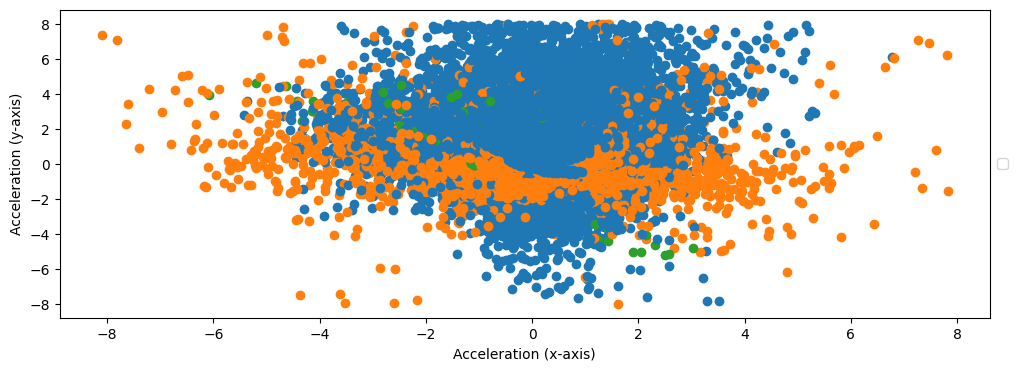

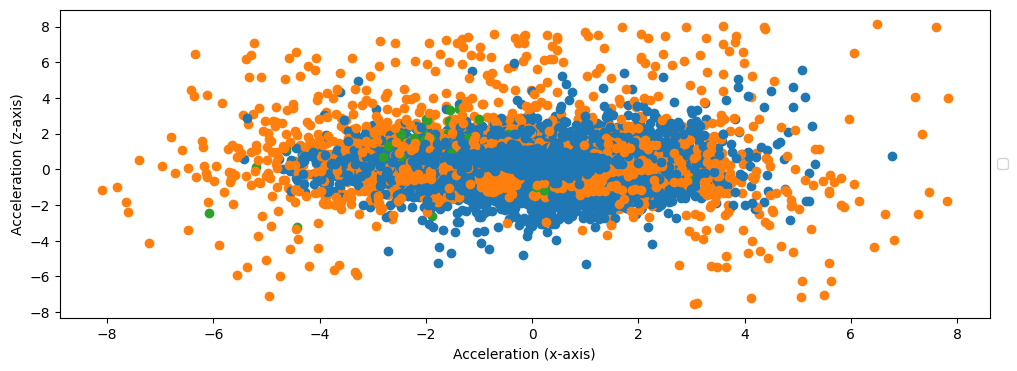

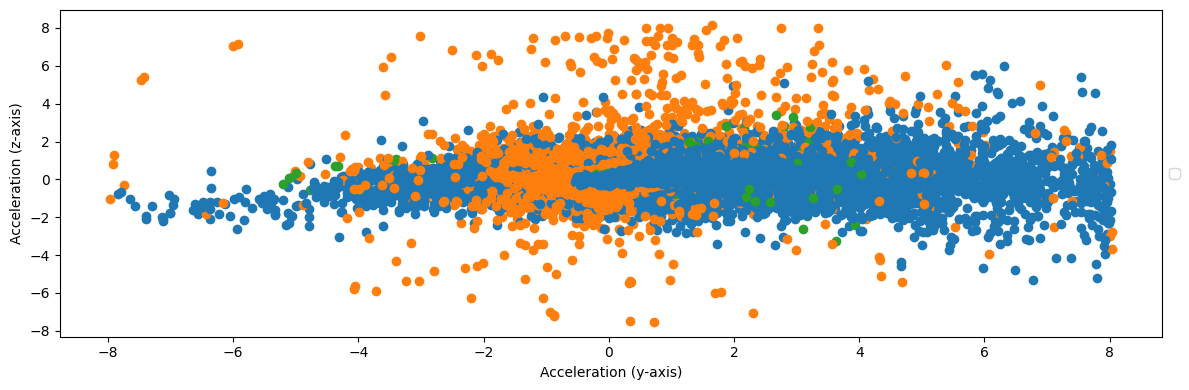

In [4]:
# Assuming df is a list of dataframes and labels is the list of labels
fig, axs = plt.subplots(3, 3)
# Create a color map for unique labels
label_colors = {label: f"C{i}" for i, label in enumerate(set(labels))}

# Plotting line plots for each axis
plt.figure(figsize=(12, 6))
for i in range(len(df)):
    label = labels[i]
    color = label_colors[label]
    plt.plot(df[i]['time'], df[i]['x'],  color=color)
plt.xlabel('Time')
plt.ylabel('Acceleration (x-axis)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(12, 6))
for i in range(len(df)):
    label = labels[i]
    color = label_colors[label]
    plt.plot(df[i]['time'], df[i]['y'],  color=color)
plt.xlabel('Time')
plt.ylabel('Acceleration (y-axis)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(12, 6))
for i in range(len(df)):
    label = labels[i]
    color = label_colors[label]
    plt.plot(df[i]['time'], df[i]['z'],  color=color)
plt.xlabel('Time')
plt.ylabel('Acceleration (z-axis)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Plotting scatter plots for different axes
plt.figure(figsize=(12, 4))
for i in range(len(df)):
    label = labels[i]
    color = label_colors[label]
    plt.scatter(df[i]['x'], df[i]['y'],  color=color)
plt.xlabel('Acceleration (x-axis)')
plt.ylabel('Acceleration (y-axis)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(12, 4))
for i in range(len(df)):
    label = labels[i]
    color = label_colors[label]
    plt.scatter(df[i]['x'], df[i]['z'],  color=color)
plt.xlabel('Acceleration (x-axis)')
plt.ylabel('Acceleration (z-axis)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(12, 4))
for i in range(len(df)):
    label = labels[i]
    color = label_colors[label]
    plt.scatter(df[i]['y'], df[i]['z'],  color=color)
plt.xlabel('Acceleration (y-axis)')
plt.ylabel('Acceleration (z-axis)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

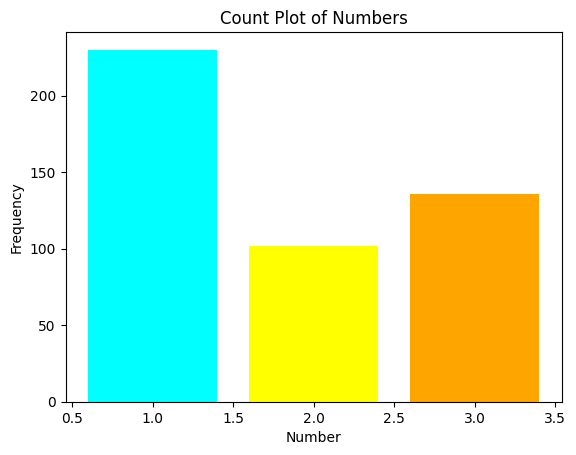

In [5]:
# Class distribution
# Calculate the unique values and their frequencies
unique_values, frequencies = np.unique(labels, return_counts=True)

# Plotting the count plot
plt.bar(unique_values, frequencies, color = [ 'cyan', 'yellow', 'orange'])
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Count Plot of Numbers')
plt.show()

In [6]:
from features import Features
import inspect
import pandas as pd
import numpy as np

def calc_features(df):
    f = Features()
    attrs = (getattr(f, name) for name in dir(f))
    methods = filter(inspect.ismethod, attrs)
    df_features = pd.DataFrame()

    for signals in df:
        names = []
        values = []
        for columns in signals.columns[:-1]: 
            signal = np.array(signals[columns])
            f = Features()
            attrs = (getattr(f, name) for name in dir(f))
            methods = filter(inspect.ismethod, attrs)
            methods = filter(inspect.ismethod, attrs)
            for method in methods:
                names.append(method.__name__ + '_' + columns)
                values.append(getattr(f, method.__name__)(signal))
        
        df_new = pd.DataFrame(values, index=names).T
        if df_features.empty:
            df_features = df_new
        else:
            df_features = pd.concat([df_features,df_new])
                
    return df_features

In [7]:
tsfeat = calc_features(df_resampled)

[0.13678    0.14025015 0.13313174 ... 0.11232846 0.10041908 0.084561  ]
[0.98086    0.98086    0.98135595 ... 0.98483404 0.98086301 0.99666   ]
[-0.028898   -0.02137277 -0.03306342 ... -0.01950299 -0.02447419
 -0.033282  ]
[-0.14       -0.16375362 -0.15573583 ... -0.18960601 -0.17402239
 -0.17494   ]
[0.95322    0.95717941 0.96901372 ... 0.81105    0.83867803 0.86239   ]
[0.20337    0.18977076 0.19071101 ... 0.11141724 0.12875622 0.15994   ]
[-0.96907    -0.96504973 -0.96502379 ...  0.16904651  0.16726761
  0.15383   ]
[0.1555     0.15747759 0.15155    ... 1.72320669 1.76870774 1.7628    ]
[0.18588    0.18628052 0.18616741 ... 0.50431252 0.49931451 0.4768    ]
[-0.24535    -0.25489491 -0.27175977 ... -0.86506597 -0.89761535
 -0.90209   ]
[ 0.92163     0.93744142  0.95719052 ... -0.26307716 -0.33220974
 -0.34209   ]
[0.49329    0.47542144 0.43392243 ... 0.07532102 0.08637663 0.10118   ]
[ 1.43880000e-01  1.35507419e-01  1.39347518e-01  1.51420334e-01
  1.42830382e-01  1.22468200e-01  1.

In [8]:
tsfeat

,auc_x,autocorr_x,calc_max_x,calc_mean_x,calc_median_x,calc_min_x,calc_std_x,calc_var_x,distance_x,interq_range_x,...,median_abs_deviation_z,median_abs_diff_z,median_diff_z,negative_turning_z,pk_pk_distance_z,positive_turning_z,slope_z,sum_abs_diff_z,total_energy_z,zero_cross_z
0,1.557371,89.024744,0.693289,0.066696,0.061151,-0.784883,0.186931,0.034943,2260.563161,0.154148,...,0.072863,0.008507,-0.000759,428.0,0.592104,429.0,-0.000002,32.922238,1.857917,98.0
0,2.171963,197.427118,0.470244,-0.163410,-0.127067,-1.603301,0.266975,0.071276,2016.743751,0.225793,...,0.081479,0.012172,0.001242,293.0,1.692158,292.0,-0.000028,52.561213,6.522787,96.0
0,3.710821,639.263726,0.177058,-0.478372,-0.434809,-1.057066,0.436291,0.190350,1524.121979,0.927964,...,0.061639,0.007102,0.000148,306.0,0.624218,306.0,0.000082,16.393202,19.311767,0.0
0,4.674279,970.543685,0.281936,-0.454445,-0.090394,-4.354404,0.545581,0.297658,1927.563380,0.998039,...,0.177410,0.006833,-0.000236,424.0,3.948470,423.0,-0.000239,28.823818,21.526363,10.0
0,1.229189,89.273891,1.308709,0.255591,0.248850,-0.325685,0.177186,0.031395,923.036793,0.099313,...,0.055582,0.008076,0.000255,168.0,1.313669,168.0,-0.000026,14.809155,7.223184,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.668226,84.415073,0.357072,-0.093123,-0.078327,-0.717267,0.158796,0.025216,2491.251695,0.168137,...,0.052868,0.010829,0.000204,410.0,1.601512,409.0,-0.000023,62.588193,3.983331,155.0
0,4.277674,627.349664,0.325693,-0.343151,-0.447180,-4.419523,0.408205,0.166631,2208.621881,0.671095,...,0.401808,0.005657,0.000524,449.0,2.478526,451.0,-0.000514,38.000464,64.485289,105.0
0,3.888104,232.494029,1.057705,0.127222,0.129152,-0.532254,0.192271,0.036968,4376.087493,0.205037,...,0.074472,0.013299,-0.000161,657.0,1.272947,657.0,-0.000005,101.284136,8.372730,208.0
0,1.618084,84.985850,0.569132,-0.067676,-0.039332,-0.700288,0.174586,0.030480,2424.072954,0.185331,...,0.049631,0.009551,0.000139,440.0,0.888032,440.0,-0.000004,37.020825,24.483075,0.0


In [9]:
# Division in Train and Test set (66%-33%)
X_train, X_test, Y_train, Y_test = train_test_split(tsfeat, data['class'], test_size=0.33, random_state=1999)

In [10]:
# Classification with Random Forests
classifier = RandomForestClassifier(min_samples_split=10)

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
model = classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       1.00      0.99      0.99        79
     falling       0.88      1.00      0.94        29
      others       0.98      0.91      0.95        47

    accuracy                           0.97       155
   macro avg       0.95      0.97      0.96       155
weighted avg       0.97      0.97      0.97       155

Accuracy: 96.7741935483871%


In [12]:
# Classification with KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       0.99      0.97      0.98        79
     falling       0.93      0.93      0.93        29
      others       0.92      0.94      0.93        47

    accuracy                           0.95       155
   macro avg       0.94      0.95      0.95       155
weighted avg       0.96      0.95      0.96       155

Accuracy: 95.48387096774194%


In [17]:
# Classification with Naive Bayes
from sklearn.naive_bayes import GaussianNB 
classifier = GaussianNB()

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       1.00      0.99      0.99        79
     falling       0.85      1.00      0.92        29
      others       0.98      0.89      0.93        47

    accuracy                           0.96       155
   macro avg       0.94      0.96      0.95       155
weighted avg       0.97      0.96      0.96       155

Accuracy: 96.12903225806451%


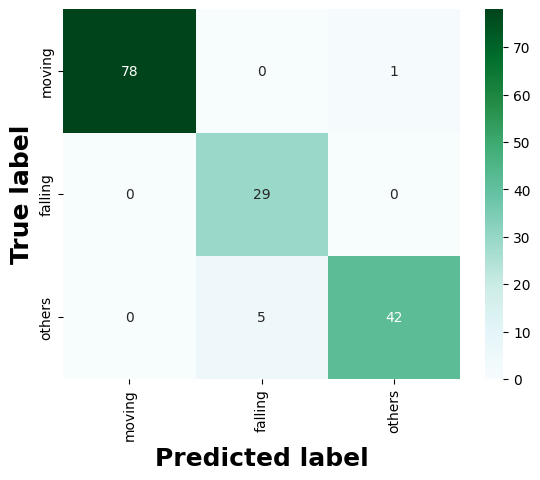

In [19]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()